*Using flc_env conda environment*

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import numpy as np

In [3]:
data_arrays = []
month_str = "2024 Jul"

for day in range(1, 32):  # Days 1 to 31
    date_str = f"202407{day:02d}"  # Format the day with leading zero if needed
    # Open the DataArray for the current day
    file_path = f"composite/global/global_{date_str}.nc"
    data_array = xr.open_dataarray(file_path)
    
    # Set negative values to NaN (only keep positive values)
    data_array = data_array.where(data_array > 0)

    data_arrays.append(data_array)

# Stack the DataArrays along a new dimension, then take the mean across that dimension
mean_FLCI = xr.concat(data_arrays, dim="time").mean(dim="time")

Calculating the interquartile range (IQR) and standard deviation:

In [5]:
combined_data = xr.concat(data_arrays, dim="time")

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
q1 = combined_data.quantile(0.25, dim="time")
q3 = combined_data.quantile(0.75, dim="time")

# Calculate the IQR
IQR = q3 - q1

# Standard deviation
std_dev = combined_data.std(dim="time")

/home/jturner/miniconda3/envs/flc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [6]:
# Coefficient of Variation
cv = (std_dev / mean_FLCI) * 100

Adjusting the longitude values:

In [7]:
lons = mean_FLCI.longitude-180

Mapping the results:

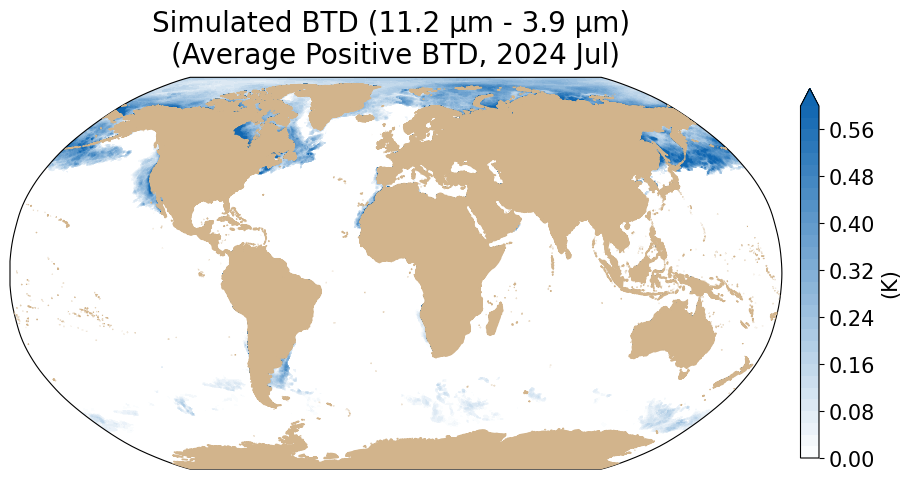

In [15]:
tool = "mean" #"IQR, mean, std_dev, cv

if tool == "mean":
    BTD = mean_FLCI
if tool == "IQR":
    BTD = IQR
if tool == "std_dev":
    BTD = std_dev
if tool == "cv":
    BTD = cv

projection=ccrs.Robinson(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---Custom colorbar
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, '#A9A9A9'), (0.5, 'white'), (1, '#1167b1')]  # +3 = blueish teal, 0 = white, -3 = grey
colors = [ '#FFFFFF', '#1167b1']
#colors = [(0, 'white'), (1, '#1167b1')]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


#---Local max and min, taking into account the zeroes from the NAN region (land)
max_BTD = BTD.where(BTD > -20).max().item()
min_BTD = BTD.where(BTD > -20).min().item()

#---Setting the colorbar levels
if tool == "mean":
    levels = np.linspace(0, 0.6, 31)
if tool == "IQR":
    levels = np.linspace(0, 0.9, 31)
if tool == "std_dev":
    levels = np.linspace(0, 0.9, 31)
if tool == "cv":
    levels = np.linspace(0, 100, 31)

#---Plotting
c=ax.contourf(mean_FLCI.longitude, mean_FLCI.latitude, BTD, cmap=cmap, extend='max', levels=levels, transform=ccrs.PlateCarree())

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

if tool == "cv":
    clb.set_label('(%)', fontsize=15)

if tool == "mean":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Average Positive BTD, "+month_str+")", fontsize=20, pad=10)
if tool == "IQR":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive IQR BTD, "+month_str+")", fontsize=20, pad=10)
if tool == "std_dev":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive standard deviation BTD, "+month_str+")", fontsize=20, pad=10)
if tool == "cv":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive Coefficient of Variation, "+month_str+")", fontsize=20, pad=10)

#--- Land in tan
land_mask = feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor=feature.COLORS['land'])
ax.add_feature(land_mask, zorder=100, edgecolor='tan', facecolor='tan')

#--- Display figure
fig.savefig("composite/monthly/flc_sim_"+month_str.replace(" ", "_")+"_"+tool, dpi=200, bbox_inches='tight')

**Plot FLCI for single date:**

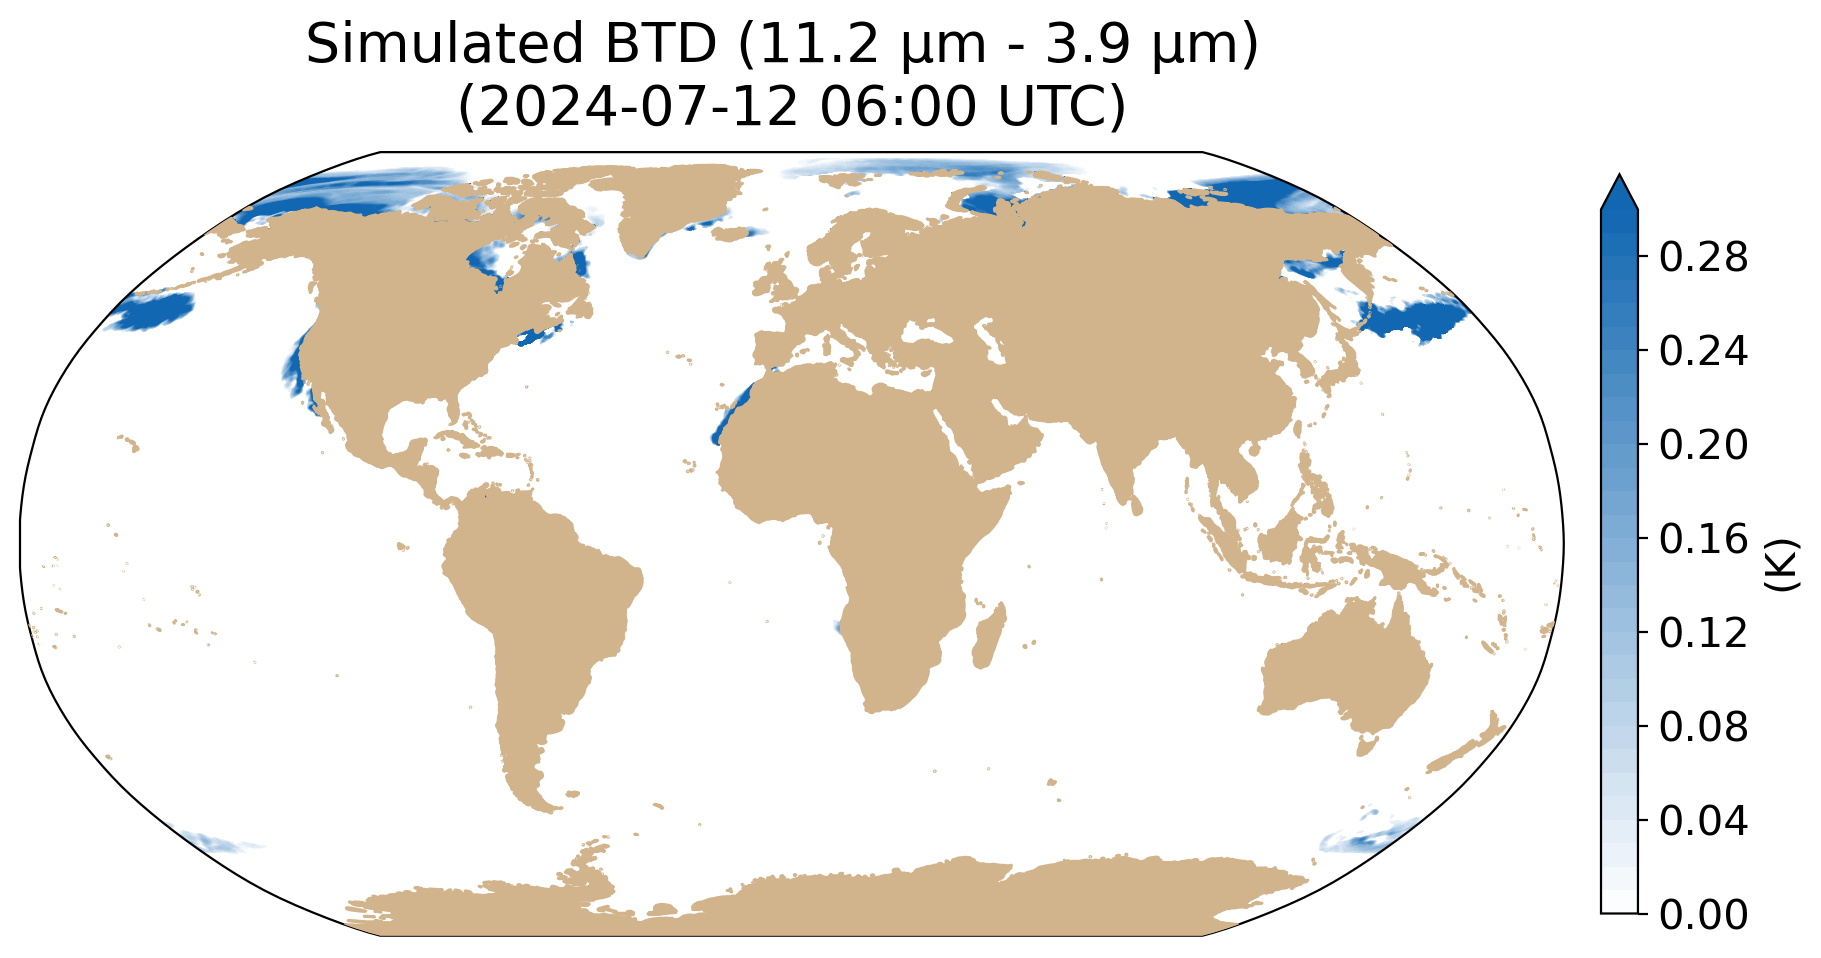

In [ ]:
date_str = "20240712"
file_path = f"composite/global/global_{date_str}.nc"
data_array = xr.open_dataarray(file_path)

BTD = data_array.where(data_array > 0)

projection=ccrs.Robinson(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---Custom colorbar
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, '#A9A9A9'), (0.5, 'white'), (1, '#1167b1')]  # +3 = blueish teal, 0 = white, -3 = grey
colors = [ '#FFFFFF', '#1167b1']
#colors = [(0, 'white'), (1, '#1167b1')]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


#---Local max and min, taking into account the zeroes from the NAN region (land)
max_BTD = BTD.where(BTD > -20).max().item()
min_BTD = BTD.where(BTD > -20).min().item()

#---Setting the colorbar levels
levels = np.linspace(0, 0.3, 31)

#---Plotting
c=ax.contourf(mean_FLCI.longitude, mean_FLCI.latitude, BTD, cmap=cmap, extend='max', levels=levels, transform=ccrs.PlateCarree())

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(2024-07-12 06:00 UTC)", fontsize=20, pad=10)

#--- Land in tan
land_mask = feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor=feature.COLORS['land'])
ax.add_feature(land_mask, zorder=100, edgecolor='tan', facecolor='tan')

#--- Display figure
fig.set_dpi(200)